In [1]:
import pandas as pd
import lightgbm as lgb

import os
import random
import pickle

# from data import read_processed_train, read_processed_val, read_processed_test

In [2]:
# For testing use only 1000 rows
train_file = os.path.join('data', 'training_set_VU_DM.csv')
# df = pd.read_csv(train_file, nrows=5000)
df = pd.read_csv(train_file)
df.sample(5)

,srch_id,date_time,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,...,comp6_rate_percent_diff,comp7_rate,comp7_inv,comp7_rate_percent_diff,comp8_rate,comp8_inv,comp8_rate_percent_diff,click_bool,gross_bookings_usd,booking_bool
4262630,286121,2013-06-14 01:54:29,5,32,NaN,NaN,73,10771,4,4.0,...,NaN,1.0,0.0,11.0,NaN,NaN,NaN,0,NaN,0
639193,42741,2013-05-17 01:47:32,9,59,NaN,NaN,59,80488,3,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0
4228629,283790,2013-04-14 22:05:24,18,129,NaN,NaN,129,68591,4,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0
3980549,267154,2013-02-11 21:12:25,5,219,NaN,NaN,219,1402,2,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0
2720418,182602,2012-12-09 17:51:57,5,219,NaN,NaN,219,105300,4,4.0,...,NaN,NaN,NaN,NaN,-1.0,0.0,23.0,0,NaN,0


In [3]:
# Add relevance column
df['relevance'] = 0

mask = df['click_bool'] == 1
df.loc[mask, 'relevance'] = 1

mask = df['booking_bool'] == 1
df.loc[mask, 'relevance'] = 5

In [4]:
# Split into train and test
TRAIN_SPLIT = 0.8

srch_ids = df['srch_id'].unique()
random.shuffle(srch_ids)

# Train
train_ids = srch_ids[:int(len(srch_ids) * TRAIN_SPLIT)]
train_df = df[df['srch_id'].isin(train_ids)]
train_df = train_df.sort_values(by=['srch_id'])

# Validation
val_ids = srch_ids[int(len(srch_ids) * TRAIN_SPLIT):]
val_df = df[df['srch_id'].isin(val_ids)]
val_df = val_df.sort_values(by=['srch_id'])

In [5]:
# Prepare data for LambdaMART

# TODO: Re-add prop_id as a feature?
# TODO: Convert date_time to a usable feature instead of just dropping it
# TODO: Be careful of relevance datatype when we change formula (currently int)

# Creating a numpy array which contains the number of properties for each search query
train_group = train_df.groupby("srch_id")["srch_id"].count().to_numpy()
# Keeping only the features on which we would train our model 
X_train = train_df.drop(["srch_id", "prop_id", "date_time", "position", "click_bool", "booking_bool", "gross_bookings_usd", "relevance"], axis = 1)
# Relevance label for train
y_train = train_df['relevance'].astype(int)

# Repeating the same process for test data
val_group = val_df.groupby("srch_id")["srch_id"].count().to_numpy()
X_val = val_df.drop(["srch_id", "prop_id", "date_time", "position", "click_bool", "booking_bool", "gross_bookings_usd", "relevance"], axis = 1)
y_val = val_df['relevance'].astype(int)

In [17]:
# Training

# Creating the ranker object
ranker = lgb.LGBMRanker(
    objective="lambdarank",
    boosting_type = "gbdt",
    n_estimators = 1000,
    # early_stopping_rounds = 50,
    importance_type = "gain",
    metric= "ndcg",
    num_leaves = 15,
    learning_rate = 0.001,
    max_depth = -1,
    label_gain =[i for i in range(max(y_train.max(), y_val.max()) + 1)])

# Training the model
ranker.fit(
      X=X_train,
      y=y_train,
      group=train_group,
      eval_set=[(X_train, y_train),(X_val, y_val)],
      eval_group=[train_group, val_group],
      eval_at=[5]
      )

[1]	training's ndcg@5: 0.297092	valid_1's ndcg@5: 0.295624
[2]	training's ndcg@5: 0.316425	valid_1's ndcg@5: 0.315497
[3]	training's ndcg@5: 0.327763	valid_1's ndcg@5: 0.327056
[4]	training's ndcg@5: 0.331804	valid_1's ndcg@5: 0.330286
[5]	training's ndcg@5: 0.338429	valid_1's ndcg@5: 0.337056
[6]	training's ndcg@5: 0.339314	valid_1's ndcg@5: 0.33801
[7]	training's ndcg@5: 0.340157	valid_1's ndcg@5: 0.337972
[8]	training's ndcg@5: 0.339972	valid_1's ndcg@5: 0.338182
[9]	training's ndcg@5: 0.339938	valid_1's ndcg@5: 0.337625
[10]	training's ndcg@5: 0.340732	valid_1's ndcg@5: 0.338351
[11]	training's ndcg@5: 0.342769	valid_1's ndcg@5: 0.340677
[12]	training's ndcg@5: 0.343564	valid_1's ndcg@5: 0.341282
[13]	training's ndcg@5: 0.343763	valid_1's ndcg@5: 0.341444
[14]	training's ndcg@5: 0.344318	valid_1's ndcg@5: 0.341695
[15]	training's ndcg@5: 0.34432	valid_1's ndcg@5: 0.342184
[16]	training's ndcg@5: 0.345051	valid_1's ndcg@5: 0.34325
[17]	training's ndcg@5: 0.344718	valid_1's ndcg@5: 0

LGBMRanker(importance_type='gain', label_gain=[0, 1, 2, 3, 4, 5],
           learning_rate=0.001, metric='ndcg', n_estimators=1000, num_leaves=15,
           objective='lambdarank')

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

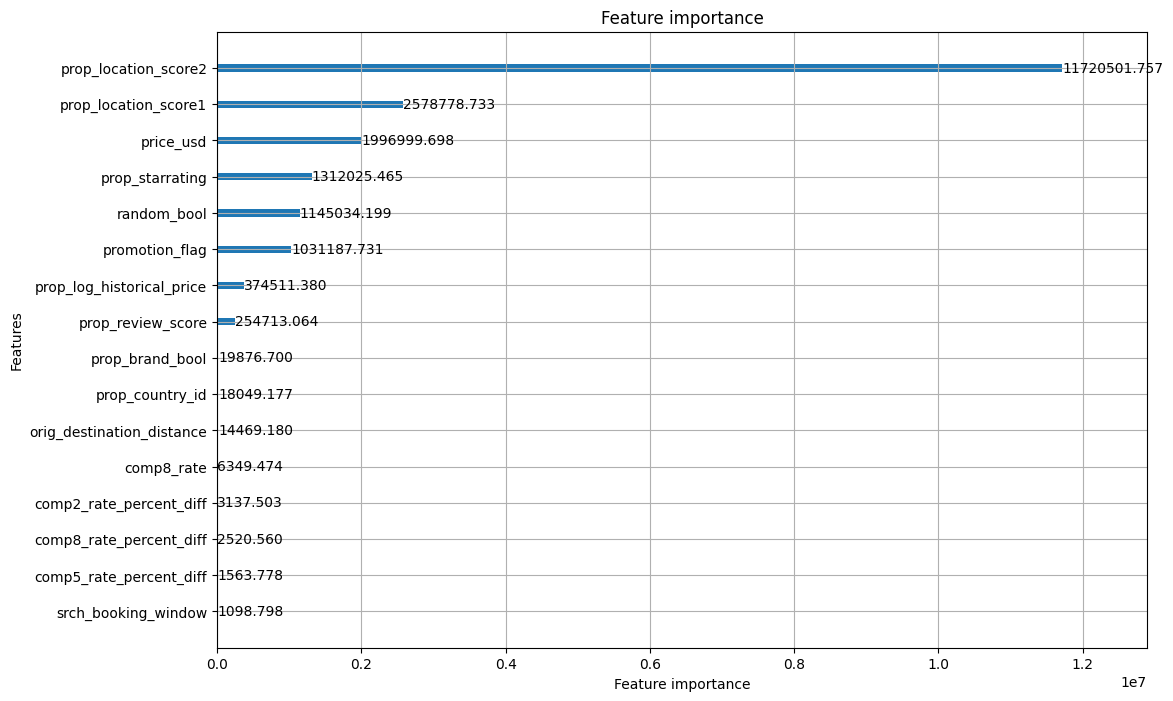

In [18]:
lgb.plot_importance(ranker, figsize = (12,8))

<Axes: title={'center': 'Metric during training'}, xlabel='Iterations', ylabel='ndcg@5'>

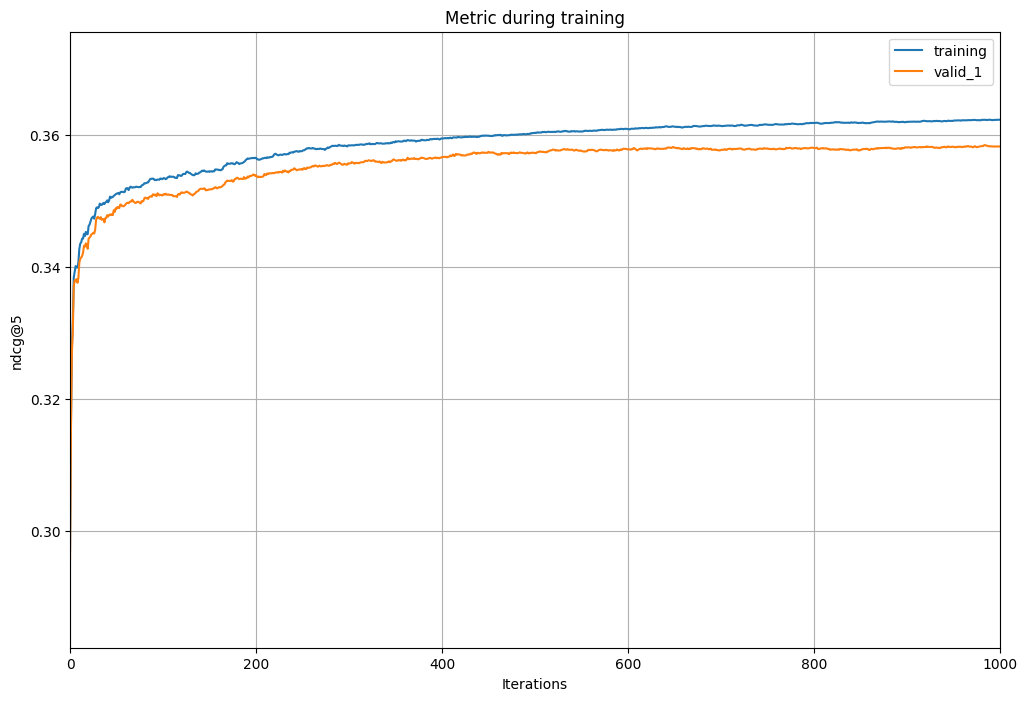

In [19]:
lgb.plot_metric(ranker, figsize = (12,8))

In [21]:
model_file = os.path.join('models', 'lambdamart1.pkl')
pickle.dump(ranker, open(model_file, 'wb'))

## Test

In [22]:
model_file = os.path.join('models', 'lambdamart1.pkl')
model = pickle.load(open(model_file, 'rb'))

In [25]:
test_file = os.path.join('data', 'test_set_VU_DM.csv')
test_df = pd.read_csv(test_file)
test_df.sample(5)

,srch_id,date_time,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,...,comp5_rate_percent_diff,comp6_rate,comp6_inv,comp6_rate_percent_diff,comp7_rate,comp7_inv,comp7_rate_percent_diff,comp8_rate,comp8_inv,comp8_rate_percent_diff
352035,23572,2013-05-24 07:18:29,5,219,NaN,NaN,219,130481,2,2.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4791601,321655,2013-03-27 12:15:42,5,219,NaN,NaN,219,94323,3,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1668663,112248,2013-04-08 19:17:53,5,219,NaN,NaN,31,23544,4,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4672077,313697,2013-04-23 08:21:33,5,219,NaN,NaN,219,108564,4,4.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,0.0,3.0
335630,22482,2013-04-19 10:17:30,5,219,NaN,NaN,219,122935,3,4.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
features = list(test_df.columns)
features.remove('srch_id')
features.remove('date_time')
features.remove('prop_id')

X_test = test_df[features].to_numpy(copy=True)

In [27]:
# Predict
test_pred = model.predict(X_test)

In [28]:
test_df['test_pred'] = test_pred
# Sort by srch_id and test_pred
test_df = test_df.sort_values(by=['srch_id', 'test_pred'], ascending=[True, False])
test_df[['srch_id', 'prop_id', 'test_pred']].head(100)


,srch_id,prop_id,test_pred
9,1,54937,0.164788
23,1,99484,0.162098
12,1,61934,0.117354
5,1,28181,0.103943
4,1,24194,0.085830
...,...,...,...
112,10,92193,0.135897
113,10,94138,0.086207
99,10,37616,0.083815
111,10,90052,0.055871


In [15]:
final_df = test_df[['srch_id', 'prop_id']]

submission_file = os.path.join('submissions', 'submission.csv')
final_df.to_csv(submission_file, index=False)

In [51]:
final_df.shape

(4959183, 2)